<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Разделение-на-train,-test" data-toc-modified-id="Разделение-на-train,-test-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Разделение на train, test</a></span></li><li><span><a href="#Fit-MyDecisionTree" data-toc-modified-id="Fit-MyDecisionTree-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Fit MyDecisionTree</a></span></li><li><span><a href="#Predict-MyDecisionTree" data-toc-modified-id="Predict-MyDecisionTree-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Predict MyDecisionTree</a></span></li><li><span><a href="#Train-with-sklearn" data-toc-modified-id="Train-with-sklearn-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Train with sklearn</a></span></li><li><span><a href="#Сравнение-метрик" data-toc-modified-id="Сравнение-метрик-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Сравнение метрик</a></span></li></ul></div>

# Задание  

1. Напишите свой алгоритм построения дерева решений для задачи бинарной классификации.  
    - критерий информативности - Энтропия Шеннона
    - критерии останова - максимальная глубина, кол-во элементов в листе, прирост энтропии < x
2. Сравните результат работы своего алгоритма с sklearn    

3. (дополнительно)  Попробуйте не делать One-Hot-Encoding для категориальных переменных, а добавить их обработку в свой алгоритм. Сравните качество работы алгоритма с предыдущим решением.

## Подготовка данных
Рассмотрим задачу "Титаник" https://www.kaggle.com/c/titanic/data. Необходимо предсказать выживет пассажир или нет.

In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

In [63]:
# считаем данные из файла в pandas DataFrame
df = pd.read_csv("train.csv")

# зафиксируем целевую переменную и удалим ее из данных
y = df['Survived']
#df.drop('Survived', axis=1, inplace=True)

In [64]:
# удалим признаки PassengerId, Name, Ticket и Cabin из данных
df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

# заполним пропуски в признаке Age обучающей выборки медианным значением
df['Age'].fillna(df['Age'].median(), inplace=True)

#заполним пропуски в признаке Embarked обучающей выборки самыми частыми значениями этого признака
df['Embarked'].fillna(df['Embarked'].value_counts().idxmax(), inplace=True)

#заменим категориальные признаки, используя One-Hot-Encoding
categorical = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked']
df = pd.concat([df, pd.get_dummies(df[categorical], columns=categorical, drop_first=True)],axis=1)

df.drop(categorical, axis=1, inplace=True)

In [65]:
df.head()

,Survived,Age,Fare,Pclass_2,Pclass_3,Sex_male,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,SibSp_8,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Embarked_Q,Embarked_S
0,0,22.0,7.2500,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1
1,1,38.0,71.2833,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,26.0,7.9250,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,1,35.0,53.1000,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,35.0,8.0500,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1


## Разделение на train, test

In [66]:
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size = 0.1, random_state = 13)

In [67]:
print ('Train: ' + str(len(X_train)))
print ('Test: ' + str(len(X_test)))

Train: 801
Test: 90


## Fit MyDecisionTree  
Напишите свою функцию построения дерева.

Структуру дерева можно задать, например, словарем следующего вида:  
```python
{'feature_name': 'Age', # название фичи 
'threshold': 20, # порог разбиения
'left': 0,  # ссылка на левое поддерево, задан доминирующий класс
'right': 1} # ссылка на правое поддерево, задан доминирующий класс
```

In [68]:
class Node(object):
    def __init__(self, feature_name = None, threshold = None, left = None, right = None):
        self.feature_name = feature_name
        self.threshold = threshold
        self.left = left
        self.right = right

    def droper(self):
        self.left = None
        self.right = None


class leaf(object):
    def __init__(self, target = None, left = None, right = None):
        self.target = target
        self.left = left
        self.right = right

In [69]:
Class = pd.Series([])
Class[0] = 0
Class[max(Class.index) + 1] = df['Age'].value_counts().idxmax()

Class = pd.Series()
for column in df:
    Class[column] = df[column].value_counts().idxmax()

<ipython-input-69-3462762297ac>:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  Class = pd.Series([])
<ipython-input-69-3462762297ac>:5: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  Class = pd.Series()


In [70]:
def get_target(df):
    """
        Функция ищет доминирующий класс во входном DataFrame
        Input - DataFrame
        Output - 0 или 1

        Например, в исходных данных 490 нулей и 311 единиц.
        Функция должна вернуть 0.
    """
    x = df['Survived'].value_counts().idxmax()
    return x


def get_entropy(target):
    """
        Функция считает энтропию заданного множества.
        Input - таргет (тип - pandas.core.series.Series)

        Output - значение энтропии (тип - float)
    """
    # YOUR CODE HERE
    entropy = 0
    counts = target.value_counts()
    for value in counts.keys():
        entropy -= (counts[value] / target.count()) * (np.log2(counts[value] / target.count()))

    return float(entropy)



def feature_separation(df, f_name):
    """
        Функция ищет лучшее разбиение для данной фичи.
        Input - df: DataFrame с 2 атрибутами (feature, target)// это мой target из get_target,
                f_name: название фичи (для которой ищем разбиение)

        Output - прирост энтропии, порог разбиения
    """
    # YOUR CODE HERE
    delta_entropy = 0
    threshold = 0
    _length = df.shape[0]
    _entropy = get_entropy(df['Survived'])
    counts = df[f_name].value_counts()
    if counts.count() == 2:
        mask = df[f_name] % 2 == 0
        df1, df2 = df[mask], df[~mask]
        length1, length2 = df1.shape[0], df2.shape[0]
        First_entropy, Second_entropy = get_entropy(df1['Survived']), get_entropy(df2['Survived'])
        w_entropy = np.abs(First_entropy * (length1 / _length) + Second_entropy * (length2 / _length))
        delta_entropy = _entropy - w_entropy
        threshold = 0.5
    else:
        for elem in df[f_name]:
            mask = df[f_name] < elem
            df1, df2 = df[mask], df[~mask]
            length1 = df1.shape[0]
            length2 = df2.shape[0]
            First_entropy, Second_entropy = get_entropy(df1['Survived']), get_entropy(df2['Survived'])
            w_entropy = np.abs(First_entropy * (length1 / _length) + Second_entropy * (length2 / _length))
            if (_entropy - w_entropy > delta_entropy):
                delta_entropy = _entropy - w_entropy
                threshold = elem

    return (delta_entropy, threshold)


def best_separation(df):
    """
        Функция выбирает фичу для разбиения, которая даст максимальный прирост энтропии.
        Input - исходный DataFrame

        Output - словарь следующиего вида
        {'feature_name': sep_feature, 'threshold': threshold, 'groups': groups}

            sep_feature - название фичи для разбиения (тип - String)
            threshold - порог разбиения (тип - float)
            groups - tuple из двух поддеревьев (df_left, df_right)
    """
    best = 0
    sep_feature, threshold = None, None
    all_features = [c for c in df.columns.tolist() if c != 'Survived']
    for feature in all_features:
        profit, thresh = feature_separation(df, feature)
        if (profit > best):
            best, sep_feature, threshold = profit, feature, thresh
    if (sep_feature == None):
        return Node(None, None, df, pd.DataFrame())

    mask = df[sep_feature] < threshold
    df1, df2 = df[mask], df[~mask]

    return Node(sep_feature, threshold, df1, df2)


def split(main, max_depth, depth):
    """
        Рекурсивная функция для построения дерева
        Input - Node: корень дерева  // {sep_feature,threshold,groups}
                max_depth: максимальная глубина дерева
                depth: текущая глубина дерева
    """
    print(main.left.shape, main.right.shape, main.feature_name, main.threshold)
    df_left, df_right = main.left, main.right
    main.droper()

    # проверяем, есть ли разбиение
    if len(df_left) == 0 or len(df_right) == 0:
        if len(df_left) == 0:
            target = get_target(df_right)
            main.left = None
            main.right = leaf(target, left=None, right=True)
        else:
            print('back')
            target = get_target(df_left)
            main.right = None
            main.left = leaf(target, left=True, right=None)
        return

    # проверяем максимальную глубину
    if depth >= max_depth:
        target = get_target(df_right)
        main.right = leaf(target, left=None, right=True)
        target = get_target(df_left)
        main.left = leaf(target, left=True, right=None)
        return

    else:
        best_sep = best_separation(df_left)
        if (best_sep.threshold == None and best_sep.feature_name == None):
            main.left = leaf(target=get_target(df_left), left=True, right=None)
        else:
            main.left = best_sep
            split(main.left, max_depth, depth + 1)

        best_sep = best_separation(df_right)
        if (best_sep.threshold == None and best_sep.feature_name == None):
            main.right = leaf(target=get_target(df_right), left=None, right=True)
        else:
            main.right = best_sep
            split(main.right, max_depth, depth + 1)
        
        
def fit_my_tree(df, max_depth):
    """
        Функция для обучения дерева
        Input - df: DataFrame
                max_depth: максимальная глубина дерева
    """
    root = best_separation(df)
    split(root, max_depth, 1)

    return root

In [71]:
my_tree = fit_my_tree(X_train, 3)

(281, 20) (520, 20) Sex_male 0.5
(152, 20) (129, 20) Pclass_3 0.5
(60, 20) (92, 20) Fare 29.0
(109, 20) (20, 20) Fare 25.4667
(367, 20) (153, 20) Fare 26.2875
(14, 20) (353, 20) Age 15.0
(4, 20) (149, 20) Fare 26.55


## Predict MyDecisionTree  

In [72]:
def predict_raw(row, tree):
    """
        Функция предсказывает класс для 1 строки DataFrame.
        
        Input - row: строка DataFrame
                tree: обученное дерево на предыдущем шаге (тип - dict)// node
    """    
    if row[tree.feature_name] < tree.threshold:
        if type(tree.left) == type(Node()):
            return predict_raw(row, tree.left)
        else:
            return tree.left.target
        
    else:
        if type(tree.right) == type(Node()):
            return predict_raw(row, tree.right)
        else:
            return tree.right.target
        
def predict_my_tree(df, tree):
    """
        Функция предсказывает класс для исходного DataFrame.
        
        Input - df: исходный DataFrame
                tree: обученное дерево на предыдущем шаге (тип - dict)
                
        Output - предсказанные классы (тип - pandas.core.series.Series)
    """      
    predict = pd.Series()   
    for index, row in df.iterrows():

        prediction = pd.Series(predict_raw(row, tree), [index])
        predict = predict.append(prediction)    

    return predict

In [73]:
my_pred_test = predict_my_tree(X_test, my_tree)

<ipython-input-72-ade7f63f0834>:29: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  predict = pd.Series()


In [74]:
my_pred_train = predict_my_tree(X_train, my_tree)

<ipython-input-72-ade7f63f0834>:29: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  predict = pd.Series()


## Train with sklearn 

Обучите дерево, используя библиотеку sklearn. Задайте те же параметры, что и при обучении своего дерева.  

Сравните метрики и попробуйте улучшить ваше дерево.

In [75]:
clf_tree = DecisionTreeClassifier(criterion='entropy', random_state=0)

X_train_new = X_train.copy()
X_train_new.drop('Survived', axis=1, inplace=True)
X_test_new = X_test.copy()
X_test_new.drop('Survived', axis=1, inplace=True)
# обучаем дерево
clf_tree.fit(X_train_new, y_train)

# предсказание на тестовой и обучающей выборках
y_pred_test = clf_tree.predict(X_test_new)
y_pred_train = clf_tree.predict(X_train_new)

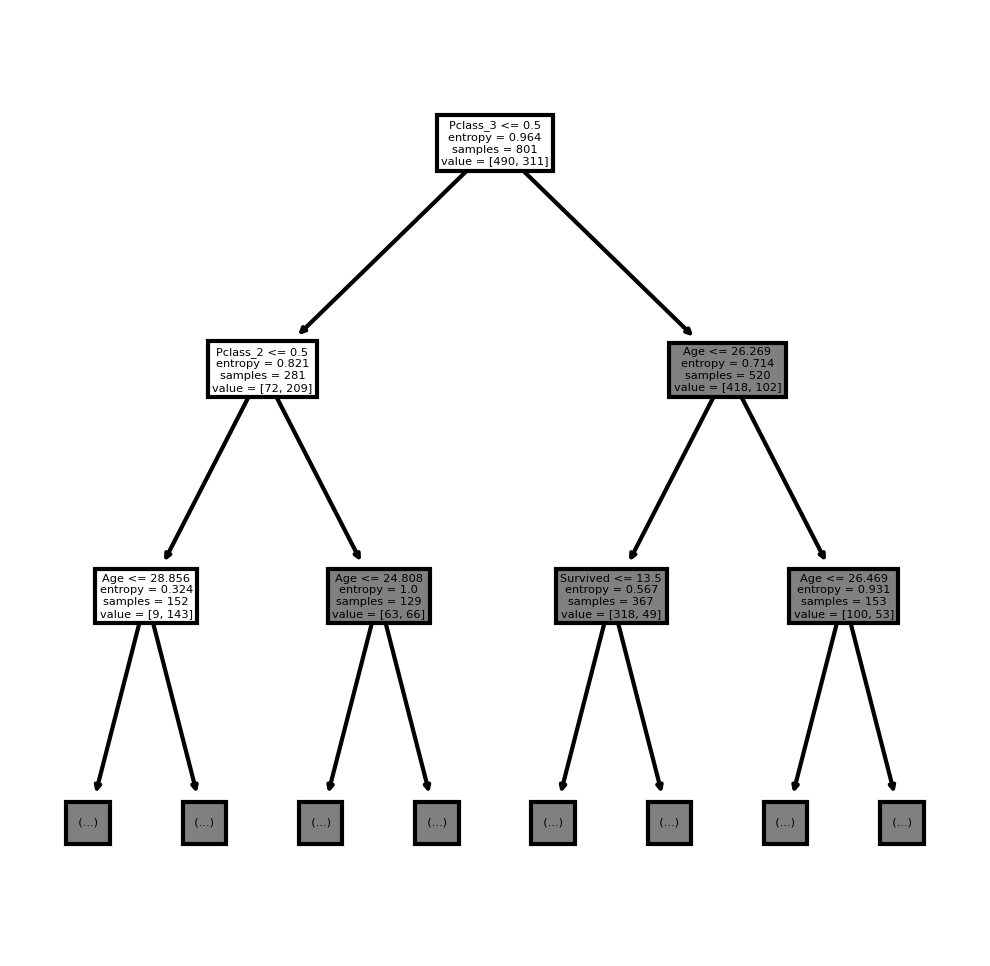

In [76]:
#Отрисовать дерево можно вот так:   
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=300)
tree.plot_tree(clf_tree, feature_names = X_train.columns,max_depth = 2);

## Сравнение метрик

In [77]:
# метрики при обучении, используя библиотеку sklearn
skl_roc_train = roc_auc_score(y_train, y_pred_train)
skl_roc_test = roc_auc_score(y_test, y_pred_test)
 
# метрики при обучении, используя собственный алгоритм
my_roc_train = roc_auc_score(y_train, my_pred_train.dropna())
my_roc_test = roc_auc_score(y_test, my_pred_test)

In [78]:
assert abs(my_roc_test - 0.6) >= 0.2